In [1]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [2]:
%cd ../gdrive/MyDrive/Kaggle/rainforestaudio/downloads

/gdrive/MyDrive/Kaggle/rainforestaudio/downloads


In [3]:
!ls

birds-crocro-augmentation-transferlearning.ipynb
logs
mySubmission_david_2.csv
mySubmission_david.csv
sample_submission.csv
soundClassCRNNGEN2.0267acc_val0.4295_train0.6451.hdf5
soundClassCRNNGEN2.0410acc_val0.3953_train0.4853.hdf5
soundClassCRNNGEN2.0532acc_val0.4209_train0.5826.hdf5
soundClassCRNNGEN2.3007acc_val0.3312_train0.4331.hdf5
soundClassCRNNGEN2.5034acc_val0.3590_train0.4047.hdf5
soundClassCRNNGEN2.7111acc_val0.2099_train0.1248.hdf5
soundClassCRNNGEN2.7740acc_val0.3077_train0.3364.hdf5
soundClassCRNNGEN2.9892acc_val0.2000_train0.1860.hdf5
test
test.zip
train
train.csv
train_fp.csv
train_tp.csv
train.zip


In [4]:
#!mkdir test
#!mkdir train

In [5]:
#!unzip "test.zip" -d test
#!unzip "train.zip" -d train

<center>
    <img src= "https://d13z1xw8270sfc.cloudfront.net/origin/320545/dsc_0081.jpg" width="800">
</center>


<head>
<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Lobster&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=Roboto&display=swap" rel="stylesheet">
</head>

<h1 style="color:GREEN; font-family: 'Roboto', sans-serif; text-align:center; font-size:30px">AUDIO ANALYSIS AND DATA AUGMENTATION WITH TENSORFLOW 📚💬</h1>
<hr>

<h1 style="text-align:left; font-family:Audiowide"> ABOUT: </h1>

<h3 style="text-align:center">Hi everyone, this is one of my first notebooks here on Kaggle so i hope that you could enjoy. So here we go, my engineer degree makes me think in this project like a signal processing, nothing special on this kind of project, in general terms a sound is a signal over time taking by a microphone. That’s the reason why other goodfellas out there face this problem in a similar way. This project demands us to use fast Fourier transform and MFCC to extract feature from the wave sound, these techniques allow us to see inside the wave sound and understand the behavior over time for the different frequencies that compounds that sound.</h3>

<h3 style="text-align:center">Maybe you ask, why did i use those techniques? what’s so special? I tell you what, you already have a similar algorithm inside your brain that allows you to differentiate between bass and sharp sounds, also you could perceive the difference between a sound at 100Hz and 400Hz, but is very  difficult perceive a difference between a sound at 10Khz and 12Khz, that’s because we didn’t perceive the sound in a linear way, that’s why we use MFCC which is a combination of algorithms among them MEL, which compress frequencies representation from linear to logarithmic. About this topic I going to write bellow on his corresponding cell, so check it out.</h3>

<h3 style="text-align:center">Finally, I going to face this problem using ConvNN-BI.LSMT-LSTM-ML to create a model to classify every clip of 5 s length, then add noise to those clip to augment our data, all this using a generator for TensorFlow. Hence, for the TEST prediction I’ll turn into little audio clips every audio test and them make the inference and merge all of them and create my submission table. If you have any other ideas or opinions, please let me know in the comments bellow. </h3>


<h2 style="text-align:center; font-family:'Lobster', cursive">Let's do it!</h2>

<h1 style="text-align:left; font-family:Audiowide"> Audio Classification Approach </h1>

<h3 style="text-align:center">The submission file only contains information about species detected in the audio file, so we don’t need time localization. This is a problem well known like weak annotation for <a href= "http://www.cs.cmu.edu/~yunwang/papers/cmu-thesis.pdf"> Sound Event Detection (SED) </a>. We going to analyze the submission next.</h3>

<center>
    <img src= "http://d33wubrfki0l68.cloudfront.net/508a62f305652e6d9af853c65ab33ae9900ff38e/17a88/images/tasks/challenge2016/task3_overview.png" width="800">
</center>

# 1. DataSet General file overview

* train_tp.csv - training data of true positive species labels, with corresponding time localization
* train_fp.csv - training data of false positives species labels, with corresponding time localization
* sample_submission.csv - a sample submission file in the correct format; note each species column has an s prefix.
* train/ - the training audio files
* test/ - the test audio files; the task is to predict the species found in each audio file
* tfrecords/{train,test} - competition data in the TFRecord format, which includes recording_id, audio_wav (encoded in 16-bit PCM format), and label_info (for train only), which provides a , -delimited string of the columns below (minus recording_id), where multiple labels for a recording_id are ; -delimited.

In [6]:
import numpy as np 
import pandas as pd 

# Input data files are available in the read-only "../input/" directory
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

In [7]:
# paths
sample_submission = "sample_submission.csv"
tfrecords = "tfrecords"
test_folder = "test"
train_folder = "train"
file_csv_tp = "train_tp.csv"
file_csv_fp = "train_fp.csv"

In [8]:
import gc
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import IPython.display as ipD
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
#import soundfile as sf
from scipy import signal as signaltool

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

import librosa
import librosa.display as LD

import pylab
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,LSTM,Reshape,Input, Lambda,Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard,EarlyStopping
import tensorflow.keras as keras
import time


%matplotlib inline

# 2. EDA

## 2.1 EDA CSV files

According to the metadata from Kaggle the columns have the following explanations.

* **recording_id** - unique identifier for recording
* **species_id** - unique identifier for species
* **songtype_id** - unique identifier for songtype
* **t_min** - start second of annotated signal
* **f_min** - lower frequency of annotated signal
* **t_max** - end second of annotated signal
* **f_max**- upper frequency of annotated signal
* **is_tp**- [tfrecords only] an indicator of whether the label is from the train_tp (1) or train_fp (0) file.


In [9]:
table_tp = pd.read_csv(file_csv_tp)
ipD.display(table_tp.nunique())
ipD.display(table_tp.info())
table_tp.head()

recording_id    1132
species_id        24
songtype_id        2
t_min           1162
f_min             27
t_max           1167
f_max             32
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recording_id  1216 non-null   object 
 1   species_id    1216 non-null   int64  
 2   songtype_id   1216 non-null   int64  
 3   t_min         1216 non-null   float64
 4   f_min         1216 non-null   float64
 5   t_max         1216 non-null   float64
 6   f_max         1216 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 66.6+ KB


None

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [10]:
table_fp = pd.read_csv(file_csv_fp)
ipD.display(table_fp.nunique())
ipD.display(table_fp.info())
table_fp.head()

recording_id    3958
species_id        24
songtype_id        2
t_min           6090
f_min             24
t_max           6089
f_max             30
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7781 entries, 0 to 7780
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recording_id  7781 non-null   object 
 1   species_id    7781 non-null   int64  
 2   songtype_id   7781 non-null   int64  
 3   t_min         7781 non-null   float64
 4   f_min         7781 non-null   float64
 5   t_max         7781 non-null   float64
 6   f_max         7781 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 425.6+ KB


None

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984


In [11]:
table_submission = pd.read_csv(sample_submission)
ipD.display(table_submission.nunique())
ipD.display(table_submission.info())
table_submission.head()

recording_id    1992
s0                 1
s1                 1
s2                 1
s3                 1
s4                 1
s5                 1
s6                 1
s7                 1
s8                 1
s9                 1
s10                1
s11                1
s12                1
s13                1
s14                1
s15                1
s16                1
s17                1
s18                1
s19                1
s20                1
s21                1
s22                1
s23                1
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recording_id  1992 non-null   object 
 1   s0            1992 non-null   float64
 2   s1            1992 non-null   float64
 3   s2            1992 non-null   float64
 4   s3            1992 non-null   float64
 5   s4            1992 non-null   float64
 6   s5            1992 non-null   float64
 7   s6            1992 non-null   float64
 8   s7            1992 non-null   float64
 9   s8            1992 non-null   float64
 10  s9            1992 non-null   float64
 11  s10           1992 non-null   float64
 12  s11           1992 non-null   float64
 13  s12           1992 non-null   float64
 14  s13           1992 non-null   float64
 15  s14           1992 non-null   float64
 16  s15           1992 non-null   float64
 17  s16           1992 non-null   float64
 18  s17           1992 non-null 

None

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


### 2.2. Specie ID representation

In [12]:
temp_df = table_tp["species_id"].value_counts().reset_index()  
temp_df.columns = ["specie", "count"]
temp_df.sort_values(by = "specie", inplace= True )
temp_df["specie"] = temp_df["specie"].astype(str)

temp_df_fp = table_fp["species_id"].value_counts().reset_index()  
temp_df_fp.columns = ["specie", "count"]
temp_df_fp["specie"] = temp_df_fp["specie"].astype(str)
temp_df_fp.sort_values(by = "specie", inplace= True )

trace1 = go.Bar(
                x = temp_df['specie'],
                y = temp_df['count'], name ="TP",
                marker = dict(color = 'rgb(1,200,15)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_df['count'], textposition='outside')

trace2 = go.Bar(
                x = temp_df_fp['specie'],
                y = -temp_df_fp['count'], name ="FP",
                marker = dict(color = 'rgb(250,13,92)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_df_fp['count'], textposition='outside')



layout = go.Layout(template= "plotly_dark",title = 'SPECIES DISTRIBUTION TP vs FP' , xaxis = dict(title = 'Specie ID'), yaxis = dict(title = 'Count'), height=650)
fig = go.Figure(data = [trace1,trace2], layout = layout)
fig.update_yaxes(showticklabels=False)
fig.update_layout(barmode='overlay')
fig.show()

# 2.3. Song type char representation

For a naked eye this seems to be irrelevant for the model, because exist only on two species, maybe analysis those species, could be relevant, but not for the whole model. So, song type going to be ignore this feature for now.

In the comments I’ve found that exist because some birds have two different ways to sing, that´s a cool interesting topic, so we could analyze those birds like a distinct species and by the end merge each other for the submission. *[I´ll not cover that on this notebook sorry]*

In [13]:
trace = go.Pie(labels=table_tp["songtype_id"].value_counts().index.sort_values(), 
               values=table_tp["songtype_id"].value_counts().values, 
               hoverinfo='percent+value+label', 
               textinfo='percent',
               textposition='inside',
               showlegend=True,
               marker=dict(colors=plt.cm.viridis_r(np.linspace(0, 1, 28)),
                           line=dict(color='#000000',
                                     width=2),
                          )
                  )

trace2 = go.Pie(labels=table_fp["songtype_id"].value_counts().index.sort_values(), 
               values=table_fp["songtype_id"].value_counts().values, 
               hoverinfo='percent+value+label', 
               textinfo='percent',
               textposition='inside',
               showlegend=True,
               marker=dict(colors=plt.cm.viridis_r(np.linspace(0, 1, 28)),
                           line=dict(color='#000000',
                                     width=2),
                          )
                  )

layout = go.Layout(title="Songtype ID in TP",template= "plotly_dark")
fig=go.Figure(data=[trace], layout=layout)
fig.show()

layout = go.Layout(title="Songtype ID in FP",template= "plotly_dark")
fig=go.Figure(data=[trace2], layout=layout)
fig.show()

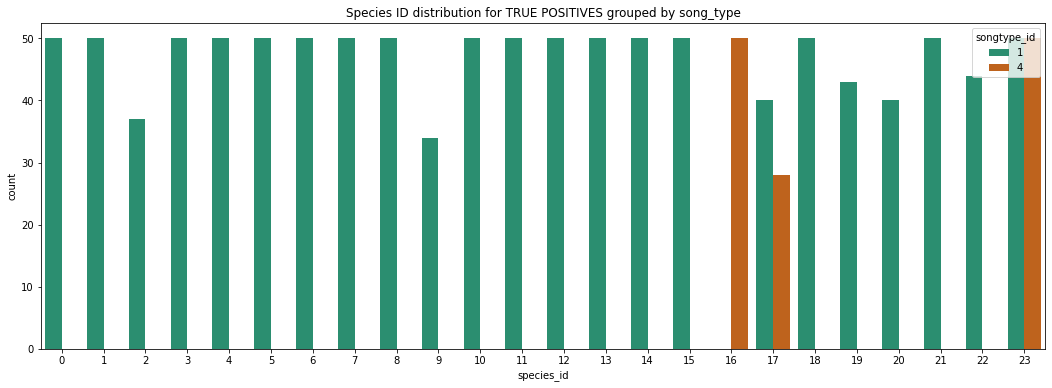

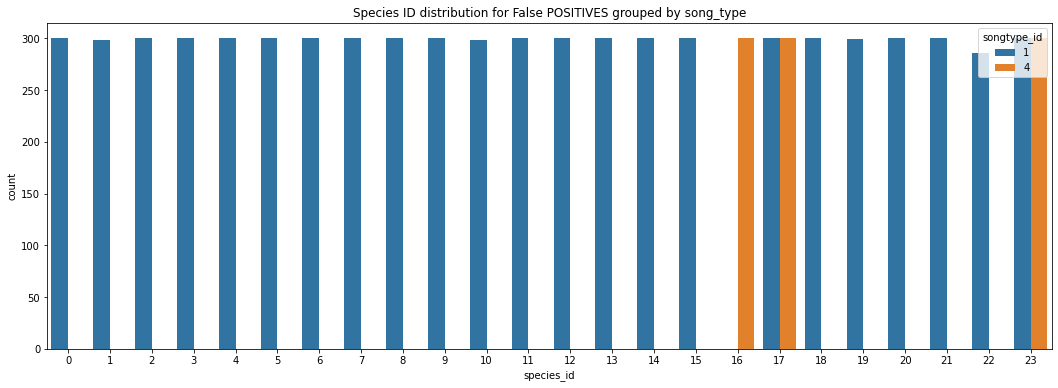

In [14]:
plt.figure(figsize=(18, 6))
sns.countplot(x="species_id", hue="songtype_id", data=table_tp, palette = sns.color_palette("Dark2", 3))
plt.title("Species ID distribution for TRUE POSITIVES grouped by song_type")
plt.show()

plt.figure(figsize=(18, 6))
sns.countplot(x="species_id", hue="songtype_id", data=table_fp)
plt.title("Species ID distribution for False POSITIVES grouped by song_type")
plt.show()

# 2.4. Frequencies behavior

In [15]:
fmean_table = table_tp[["recording_id","species_id","f_min", "f_max"]].groupby("species_id").mean().reset_index()
fmean_table.head()

,species_id,f_min,f_max
0,0,5906.25,8100.00
1,1,3843.75,5625.00
2,2,468.75,3000.00
3,3,1031.25,2812.50
4,4,2388.75,4173.75


In [16]:
fmean_table["species_id"] = fmean_table["species_id"].astype(str)

trace1 = go.Bar(
                x = fmean_table['f_max'].astype(int).apply(lambda x: np.log10(x)),
                y = fmean_table['species_id'], name ="F_max",  orientation='h',
                marker = dict(color = 'rgb(1,200,0)',
                              line=dict(color='rgb(0,0,0)',width=3.0)),
                text=fmean_table['f_max'].astype(int), textposition='outside')

trace2 = go.Bar(
                x = fmean_table['f_min'].astype(int).apply(lambda x: np.log10(x)),
                y = fmean_table['species_id'], name ="F_min", orientation='h',
                marker = dict(color = 'rgb(250,13,92)',
                              line=dict(color='rgb(0,0,0)',width=3.0)),
                text=fmean_table['f_min'].astype(int), textposition='outside')

layout = go.Layout(template= "plotly_dark",title = 'Mean - Frequencies MIN MAX for every Specie' , xaxis = dict(title = 'frequency Hz [LOG]'),
                                                                                            yaxis = dict(title = 'Specie ID'), 
                                                                                            height=650
                                                                                            )
fig = go.Figure(data = [trace2, trace1], layout = layout,)
fig.update_xaxes(showticklabels=False)
fig.update_layout(barmode='stack')
fig.show()

# 2.5 Mean - length of every audio for every specie

In [17]:
time_table = table_tp[["recording_id","species_id","t_min", "t_max"]]
time_table["dt"] = time_table["t_max"] - time_table["t_min"]
time_table = time_table[["species_id", "dt"]].groupby("species_id").mean()

temp_df = time_table.reset_index()  
temp_df.columns = ["specie", "dt"]
temp_df.sort_values(by = "specie", inplace= True )
temp_df["specie"] = temp_df["specie"].astype(str)


trace1 = go.Bar(
                x = temp_df['specie'],
                y = temp_df['dt'], name ="TP",
                marker = dict(color = 'rgb(1,200,15)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_df['dt'].apply(lambda x: round(x,2)), textposition='outside')



layout = go.Layout(template= "plotly_dark",title = 'Mean - length of every audio for every specie' , xaxis = dict(title = 'Specie ID'), yaxis = dict(title = 'Seconds (s)'), height=650)
fig = go.Figure(data = [trace1], layout = layout)
fig.update_yaxes(showticklabels=True)
fig.update_layout(barmode='overlay')
fig.show()

# 2.6. Audio exploration

The next that i going to do is, pick a random sample audio, from the folder Test and train, them open those using librosa libreri to get the audio in vector format, this is the beggining of audio analisis.

In [ ]:
# choose a sample from train and test
tr = os.path.join(train_folder, os.listdir(train_folder)[np.random.randint(0, len(os.listdir(train_folder)))])
ts = os.path.join(test_folder, os.listdir(test_folder)[np.random.randint(0, len(os.listdir(test_folder)))])

# load the np array and the samping rate
trx, trsr = librosa.load(tr)
tsx, tssr = librosa.load(ts)
recording_id_train_sample = (tr.split("/")[-1]).split(".")[0]
recording_id_test_sample = (ts.split("/")[-1]).split(".")[0]

# Print audio conincidences inside the dataset
print("="*10, "Training Sample", "="*10)
ipD.display(table_fp.append(table_tp, ignore_index=True)[table_fp.append(table_tp, ignore_index=True)["recording_id"]==recording_id_train_sample] )
print("="*10, "Test Sample", "="*10)
print("Test Data: ", recording_id_test_sample)

In [ ]:
# print the shape and the sampling rate
print("=====Train sample=======")
print(trx.shape, trsr)
print("=====Test sample=======")
print(tsx.shape, tssr)

# 2.6.1. Audio signal Plotting


In [ ]:
def graphWaveform(signal, sr):    
    trace1 = {
      "mode": "lines", 
      "name": "Signal with last point", 
      "type": "scatter", 
      "x":[1/sr*pos for pos in range(len(signal))],
      "y":signal,
    }
    layout = {
      "title": "Waveform Audio Signal", 
      "xaxis": {
        "title": "Time (s)", 
        "titlefont": {
          "size": 14, 
          "color": "black", 
          "family": "Courier New, monospace"
        }
      }, 
      "yaxis": {
        "title": "Amp", 
        "titlefont": {
          "size": 14, 
          "color": "black", 
          "family": "Courier New, monospace"
        }
      }, 
      "legend": {
        "font": {
          "size": 12, 
          "color": "#000", 
          "family": "sans-serif"
        }, 
        "bgcolor": "#FFFFFF", 
        "traceorder": "normal", 
        "bordercolor": "#FFFFFF", 
        "borderwidth": 2
      }
    }
    fig = go.Figure(data = [trace1], layout = layout,)
    fig.show()

In [ ]:
#graphWaveform(trx, sr= trsr) # too much memory consumption, under your risk

In [ ]:
plt.figure(figsize=(20, 5))
LD.waveplot(trx, sr=trsr)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Amp []", fontsize=14)
plt.title("Audio Signal WaveForm - TRAIN SAMPLE", fontsize=16)
plt.show()
ipD.Audio(tr)

In [ ]:
plt.figure(figsize=(20, 5))
LD.waveplot(tsx, sr=tssr)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Amp []", fontsize=14)
plt.title("Audio Signal WaveForm - TEST SAMPLE", fontsize=16)
plt.show()
ipD.Audio(ts)

# 2.6.2. Audio - Feature extraction

# 2.6.2.1. Short Time Fourier Transform (STFT)

STFT is the same Fourier transform widely known, but using a window time to analyses that portion of time, then the process repeats to the whole signal in time, using a step time of course. So, in every little window time analysis we get a spectrum decomposition. This is a good approach to analyses signals, but what happen if the signal is not visible o poorly visible for our selected window time ... we change it right? ... yhea. But what happen if this change made us lost others signals? This is the limits of STFT in this kind of situation we need to use another kind of algorithm decomposition like wavelet. Don’t worry about it, it just a comment, but I hope that you get the idea or remember it.

This stft is best visualized by spectrogram plot. But what is a spectrogram? It's a spectrum of frequency of a signal, in more simples terms a one channel image.

If you want to know more about this topic check this video.

<iframe width="560" height="315" src="https://www.youtube.com/embed/NA0TwPsECUQ" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


Or in this one from 3Blue1Brown

<iframe width="560" height="315" src="https://www.youtube.com/embed/spUNpyF58BY" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
def graph_specsSTFT(signal, sr, title,x_axis, y_axis, **paramSTFT):
    """
    signal: vector representation of the sound or signal, samples over time
    sr: sample rate
    title: title of the spectrum plot
    x_axis : axis tipe for the espectrum representation
    y_axis: axis Y type for the spectrum, could be "log" or "hz"
    **paramSTFT: are the parameter takin for the stft from librosa library 
    """
    TRX = librosa.stft(signal, **paramSTFT)
    print("Shape of the stft: ", TRX.shape)
    # convert into db
    TRXdb = librosa.amplitude_to_db(abs(TRX))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(TRXdb, sr=sr, x_axis=x_axis, y_axis=y_axis)
    plt.title(title)
    plt.colorbar()
    plt.show()
    

In [ ]:
help(librosa.stft)

Help on function stft in module librosa.core.spectrum:

stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=<class 'numpy.complex64'>, pad_mode='reflect')
    Short-time Fourier transform (STFT)
    
    Returns a complex-valued matrix D such that
        `np.abs(D[f, t])` is the magnitude of frequency bin `f`
        at frame `t`
    
        `np.angle(D[f, t])` is the phase of frequency bin `f`
        at frame `t`
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)], real-valued
        the input signal (audio time series)
    
    n_fft : int > 0 [scalar]
        FFT window size
    
    hop_length : int > 0 [scalar]
        number audio of frames between STFT columns.
        If unspecified, defaults `win_length / 4`.
    
    win_length  : int <= n_fft [scalar]
        Each frame of audio is windowed by `window()`.
        The window will be of length `win_length` and then padded
        with zeros to match `n_fft`.
    
        I

In [ ]:
# Parameters for the STFT
n_fft= 1024 # n_fft/2+1 the numbers of bands to decompouse the frequencie spectrum
win_length=1024 # Windowing to analyse the signal
hop_length=int(win_length/2) # step between sequential windows over time
stft_param = {"n_fft":n_fft, "win_length" :win_length, "hop_length":hop_length }

### Spectrum for Train Sample

Shape of the stft:  (513, 2584)


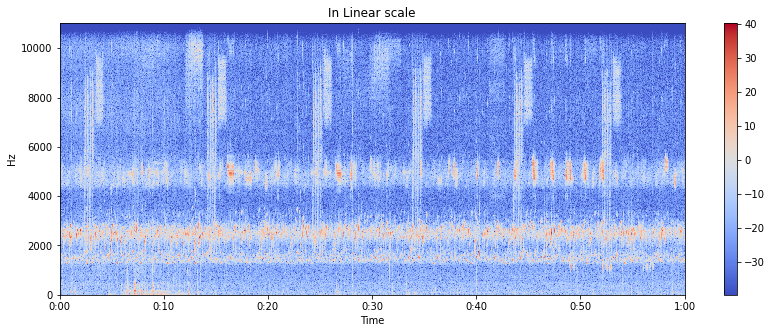

Shape of the stft:  (513, 2584)


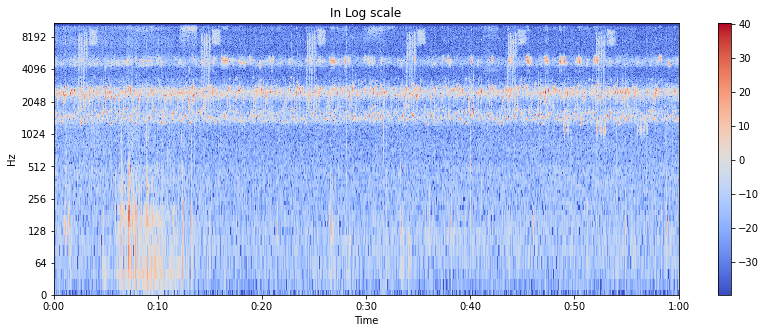

In [ ]:
graph_specsSTFT(trx,trsr,"In Linear scale", 'time', 'hz',**stft_param  )
graph_specsSTFT(trx,trsr,"In Log scale", 'time', 'log',**stft_param  )

### Spectrum for Test Sample

Shape of the stft:  (513, 2584)


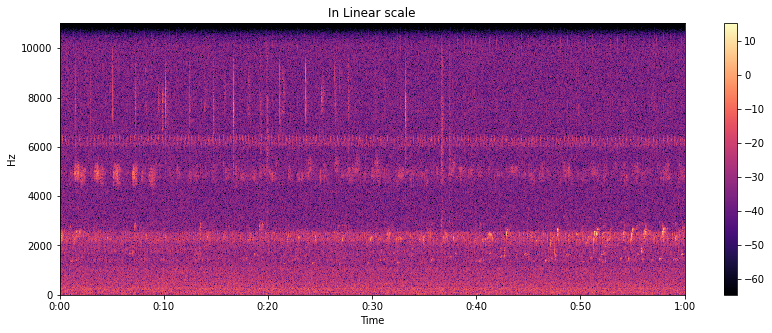

Shape of the stft:  (513, 2584)


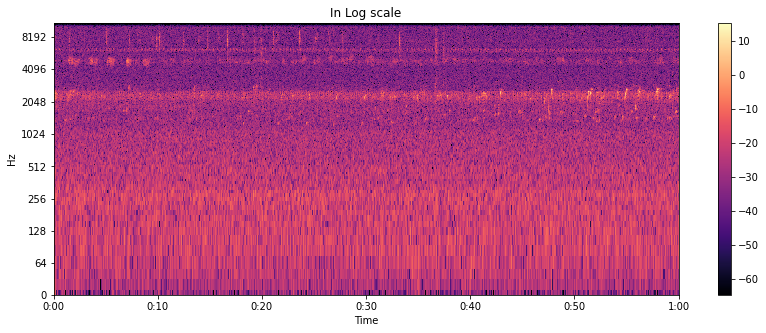

In [ ]:
graph_specsSTFT(tsx,tssr,"In Linear scale", 'time', 'hz',**stft_param  )
graph_specsSTFT(tsx,tssr,"In Log scale", 'time', 'log',**stft_param  )

# 2.6.2.2. Mel-Frequency Cepstral Coefficients(MFCCs)

MFCCs has been a hot topic in this kind of task, audio analysis, but widely used for human sound recognition (MEL), because this algorithm tries to imitate how the humans ear works. But what happen if the sound is so complex to be ear like a human does? in that case we have a problem, maybe we only need play with the STFT.
In any case, let’s see what is MFCC and how to implement.

If you want to see the original post so [check it out ](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)

Let’s begin by expanding the acronym MFCC — Mel Frequency Cepstral Co-efficients.

Ever heard the word cepstral before? Probably not. It’s spectral with the spec reversed! Why though? For a very basic understanding, cepstrum is the information of rate of change in spectral bands. In the conventional analysis of time signals, any periodic component (for eg, echoes) shows up as sharp peaks in the corresponding frequency spectrum (ie, Fourier spectrum. This is obtained by applying a Fourier transform on the time signal). This can be seen in the following image.
![](https://miro.medium.com/max/770/1*rT54GmJmFG0PU9OQHzQUVg.png)

On taking the log of the magnitude of this Fourier spectrum, and then again taking the spectrum of this log by a cosine transformation (I know it sounds complicated, but bear with me please!), we observe a peak wherever there is a periodic element in the original time signal. Since we apply a transform on the frequency spectrum itself, the resulting spectrum is neither in the frequency domain nor in the time domain and hence Bogert et al. decided to call it the quefrency domain. And this spectrum of the log of the spectrum of the time signal was named cepstrum (ta-da!).

The following image is a summary of the above explained steps.

![](https://miro.medium.com/max/770/1*pmjqw39CpC9FHb7o4CmKOA.png)
> Cepstrum was first introduced to characterize the seismic echoes resulting due to earthquakes.

Pitch is one of the characteristics of a speech signal and is measured as the frequency of the signal. Mel scale is a scale that relates the perceived frequency of a tone to the actual measured frequency. It scales the frequency in order to match more closely what the human ear can hear (humans are better at identifying small changes in speech at lower frequencies). This scale has been derived from sets of experiments on human subjects. Let me give you an intuitive explanation of what the mel scale captures.

The range of human hearing is 20Hz to 20kHz. Imagine a tune at 300 Hz. This would sound something like the standard dialer tone of a land-line phone. Now imagine a tune at 400 Hz (a little higher pitched dialer tone). Now compare the distance between these two howsoever this may be perceived by your brain. Now imagine a 900 Hz signal (similar to a microphone feedback sound) and a 1kHz sound. The perceived distance between these two sounds may seem greater than the first two although the actual difference is the same (100Hz). The mel scale tries to capture such differences. A frequency measured in Hertz (f) can be converted to the Mel scale using the following formula :
![](https://miro.medium.com/max/770/1*64Wucrt-BeUH9ZVyOHyi2A.jpeg)

Any sound generated by humans is determined by the shape of their vocal tract (including tongue, teeth, etc). If this shape can be determined correctly, any sound produced can be accurately represented. The envelope of the time power spectrum of the speech signal is representative of the vocal tract and MFCC (which is nothing but the coefficients that make up the Mel-frequency cepstrum) accurately represents this envelope. The following block diagram is a step-wise summary of how we arrived at MFCCs:

![](https://miro.medium.com/max/770/1*dWnjn5LLS0j8St53ACwqSg.jpeg)

> Here, Filter Bank refers to the mel filters (coverting to mel scale) and Cepstral Coefficients are nothing but MFCCs.

In [ ]:
help(librosa.feature.mfcc)

Help on function mfcc in module librosa.feature.spectral:

mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', **kwargs)
    Mel-frequency cepstral coefficients (MFCCs)
    
    Parameters
    ----------
    y     : np.ndarray [shape=(n,)] or None
        audio time series
    
    sr    : number > 0 [scalar]
        sampling rate of `y`
    
    S     : np.ndarray [shape=(d, t)] or None
        log-power Mel spectrogram
    
    n_mfcc: int > 0 [scalar]
        number of MFCCs to return
    
    dct_type : None, or {1, 2, 3}
        Discrete cosine transform (DCT) type.
        By default, DCT type-2 is used.
    
    norm : None or 'ortho'
        If `dct_type` is `2 or 3`, setting `norm='ortho'` uses an ortho-normal
        DCT basis.
    
        Normalization is not supported for `dct_type=1`.
    
    kwargs : additional keyword arguments
        Arguments to `melspectrogram`, if operating
        on time series input
    
    Returns
    -------
    M     : np.nd

## Train Sample MFCCs

(64, 2584)


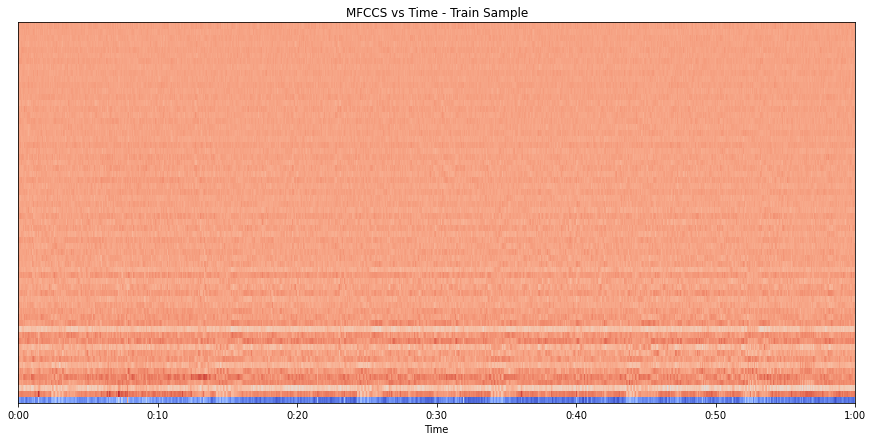

In [ ]:
mfccs = librosa.feature.mfcc(trx, sr=22000,n_mfcc=64)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
LD.specshow(mfccs, sr=trsr, x_axis='time')
plt.title("MFCCS vs Time - Train Sample")
plt.show()

## Test Sample MFCCs

(20, 2584)


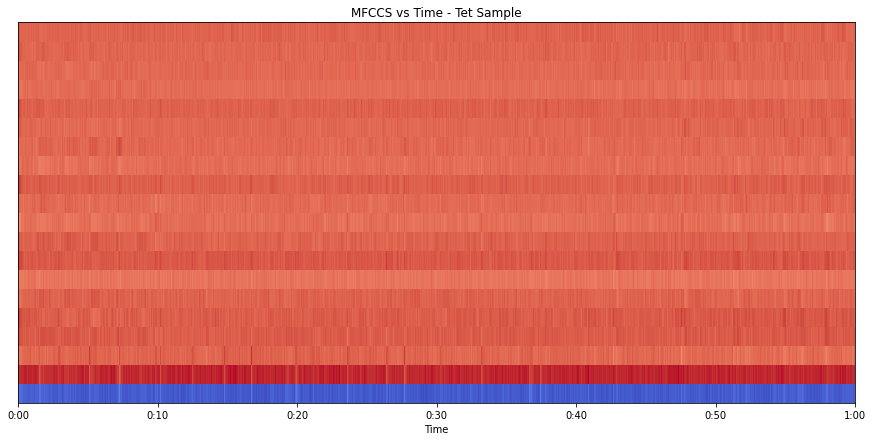

In [ ]:
mfccs = librosa.feature.mfcc(tsx, sr=tssr)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
LD.specshow(mfccs, sr=tssr, x_axis='time')
plt.title("MFCCS vs Time - Tet Sample")
plt.show()

# Mel Spectogram

In [ ]:
help(librosa.feature.melspectrogram)

Help on function melspectrogram in module librosa.feature.spectral:

melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, power=2.0, **kwargs)
    Compute a mel-scaled spectrogram.
    
    If a spectrogram input `S` is provided, then it is mapped directly onto
    the mel basis `mel_f` by `mel_f.dot(S)`.
    
    If a time-series input `y, sr` is provided, then its magnitude spectrogram
    `S` is first computed, and then mapped onto the mel scale by
    `mel_f.dot(S**power)`.  By default, `power=2` operates on a power spectrum.
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)] or None
        audio time-series
    
    sr : number > 0 [scalar]
        sampling rate of `y`
    
    S : np.ndarray [shape=(d, t)]
        spectrogram
    
    n_fft : int > 0 [scalar]
        length of the FFT window
    
    hop_length : int > 0 [scalar]
        number of samples between successive frames.
        See `librosa.core.stft`
    
    power : float > 0 [scalar

In [ ]:
melspec = librosa.feature.melspectrogram(trx, sr=trsr,n_fft =550, hop_length=128)
print(melspec.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# 3.1. Preprocessing DATA

I decided to make a simple multi classifier deep learning model, which going to classify a clip audio file with length 5 seconds. For the submission every audio will turn into little chunks of the same length then they will be classify and finally merge the results for the whole audio sample.

# 3.1. Stratify Records

This is a classification problem, so we have to stratify the species to get better metrics.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test, _, _ = train_test_split(table_tp,
                                            table_tp["species_id"], 
                                            test_size=0.20,
                                            random_state =50,
                                            stratify= table_tp["species_id"])

# 3.2. Augmented data

We have to create a class to achieve this task, TensorFlow has a simple way to create this class, let's seen below.

Embedding Pretrained model, more about this model on [TensorflowHUB VGGISH](https://tfhub.dev/google/vggish/1/) and [TensorFlowHUB Yamnet](https://tfhub.dev/google/yamnet/1)

In [ ]:
class DataAudioGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
                 df_table,
                 train_folder,
                 batch_size,
                 n_fft,        # stft params
                 win_length,   # stft params
                 hop_length,   # stft params
                 w_lenght = 5, # duration time for every clip audio
                 stride = 3,   # Only for test pourpouse, to cut audio into pises of w_lenght with stride stride jeje
                 samplerate=44000, 
                 childrens=2,  # number of synthetic audios for every original
                 shuffle=False,
                 num_classes=None, 
                 noise_var=0.0025,
                 random_state=None,
                 train_clip_folder = None,
                 pretrain_model_name='YAMNET',
                 mode = "TRAIN"):
        
        assert batch_size%(childrens+1) == 0 , 'batch_size debe ser multiplo de (childrens+1)'
        self.batch_sizes = batch_size//(childrens+1)
        self.childrens = childrens
        self.stride = stride
        self.mode = mode
        self.train_folder = train_folder
        self.train_clip_folder = train_clip_folder
        self.w_lenght  = w_lenght
        self.samplerate = samplerate
        self.n_fft      = n_fft
        self.win_length = win_length 
        self.hop_length = hop_length
        self.stft_param = {"n_fft":n_fft,  "hop_length":hop_length }#"win_length" :win_length,
        self.df_table   = df_table
        self.random_state = random_state
        self.indices = df_table.index.tolist()
        self.labels  = df_table["species_id"] if mode == "TRAIN" else []
        self.num_classes = num_classes
        self.noise_var = noise_var
        self.shuffle = shuffle
        self.noise_v = [np.stack([random.uniform(-self.noise_var,self.noise_var) for _ in range(self.samplerate*self.w_lenght)]),
                       np.stack([random.gauss(0,self.noise_var) for _ in range(self.samplerate*self.w_lenght)]),
                       ]
        self.prenet_model = hub.load('https://tfhub.dev/google/vggish/1') if pretrain_model_name == "VGGISH" else  hub.load('https://tfhub.dev/google/yamnet/1')
        self.pretrain_model_name = pretrain_model_name
        self.on_epoch_end()
        self.__info()
        
    def __info(self):
        print("Audio generator=====>")
        print("We have {:4d} original audios - {}".format(len(self.indices), self.mode))
        if self.mode == "TRAIN":
            print("We'll generate and add {:4d} synthetic audios - {}".format(len(self.indices)*self.childrens, self.mode))
        
    def __len__(self):
        #batches per epochs
        return len(self.indices) // self.batch_sizes

    def __getitem__(self, index):
        self.batch_sizes = 1 if self.mode == "TEST" else self.batch_sizes
        index = self.index[index * self.batch_sizes:(index + 1) * self.batch_sizes]
        batch = [self.indices[k] for k in index]
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
    
    def __get_data(self, batch):
        X = []
        Xym = []
        y = []
        #print(batch)
        if self.mode == "TRAIN":
            for i, id in enumerate(batch):
                y_yi = self.labels[id]
                hotencode_yi = keras.utils.to_categorical(y_yi, num_classes=self.num_classes, dtype='float32')
                signal, feature_yamnet = self.extract_audio_clip(id)
                spec_db = self.spec_transp_scal(signal)

                X.append(spec_db)       # original X
                Xym.append(feature_yamnet)
                y.append(hotencode_yi)  # original Y
                for i_aum in range(1,self.childrens+1):
                    random_base = self.random_state + int(time.time())
                    random.seed(random_base)
                    signal = self.noise_signal(signal)
                    spec_db = self.spec_transp_scal(signal)
                    X.append(spec_db)       # original X
                    Xym.append(self.extract_featur(signal))
                    y.append(hotencode_yi)  # original Y
            return (np.expand_dims(np.stack(X), axis=3 ), np.stack(Xym) )   , np.stack(y) #
        
        elif self.mode == "TEST":
            for i, id in enumerate(batch):
                signal, feature_prenet = self.extract_audio_clip(id)
                spec_db = np.stack([self.spec_transp_scal(signal_i) for signal_i in signal])
            return (np.expand_dims(spec_db, axis = 3), feature_prenet) , []
            
        
    
    def extract_audio_clip(self, index):
        record_name = self.df_table.loc[index]["recording_id"] # train_clip_folder
        record_path = os.path.join(self.train_folder, record_name+".flac")
        if self.mode == "TRAIN":
            time_start = self.df_table.loc[index]['t_min']
            time_end = self.df_table.loc[index]['t_max']
            duration = time_end-time_start

            
            #record_path_clip = os.path.join(self.train_clip_folder, record_name+ "_" + str(int(time_start*10))+".flac")
            signal, srate = librosa.load(record_path, 
                                         sr = self.samplerate, 
                                         mono = True,offset=time_start,
                                         duration = duration if duration > self.w_lenght else self.w_lenght)

    #         try :
    #             signal, srate = sf.read(record_path_clip)
    #             self.samplerate = srate
    #             return signal
    #         except:
    #             signal, srate = sf.read(record_path)
    #             self.samplerate = srate

            #signal, srate = sf.read(record_path)
            #self.samplerate = srate
        
        elif self.mode == "TEST":
            signal, srate = librosa.load(record_path, 
                                         sr = self.samplerate, 
                                         mono = True,)
            effective_length = self.samplerate * self.w_lenght
            stride = self.stride * self.samplerate
            signal = [signal[i:i+effective_length].astype(np.float32) for i in range(0, 60*self.samplerate+stride-effective_length, stride)]
            signal[-1] = signal[-1]  if len(signal[-1]) == effective_length else np.pad(signal[-1], (0,effective_length-len(signal[-1])), constant_values = (0,0))
            return np.stack(signal), np.stack([self.extract_featur(signal_) for signal_ in signal ])
        
        len_signal = len(signal)
        effective_length = self.samplerate * self.w_lenght
        time_start = 0 # time_start * self.samplerate
        time_end   = duration * self.samplerate
        
        if len_signal > effective_length:
            # Positioning sound slice
            center = np.round((time_start + time_end) / 2)
            beginning = center - effective_length / 2
            if beginning < 0:
                beginning = 0
            beginning = np.random.randint(beginning, center) # random position between center and the biggining to introduce data augmentation
            ending = beginning + effective_length
            if ending > len_signal:
                ending = len_signal
            beginning = ending - effective_length
            signal = signal[beginning:ending].astype(np.float32)
        else:
            signal = signal.astype(np.float32)
            signal = signal  if len(signal) == effective_length else np.pad(signal, (0,effective_length-len(signal)), constant_values = (0,0)) #padding or cut
            
        #sf.write(record_path_clip, signal, srate)
        
        return signal, self.extract_featur(signal)
    
    def spec_transp_scal(self, signal):
        signal = librosa.feature.melspectrogram(signal, sr=self.samplerate, **self.stft_param)# librosa.amplitude_to_db(abs(librosa.stft(signal, **self.stft_param)))
        signal = np.transpose(signal[-int(len(signal)/8):]) # transpose because we going to reshape inside the model and use a LSTM to extract time features 
        return ((signal - 1.0)/90.0) # min max scale
        
    def noise_signal(self, signal):
        max_leng         = len(signal)
        noise = random.randint(0,2)
        
        if noise == 0:
            signal = np.roll(signal + self.noise_v[0] ,int(self.samplerate/random.randint(2,4)))
        elif noise == 1:
            signal = np.roll(signal + self.noise_v[1] ,int(self.samplerate/random.randint(5,10))) 
        else: 
            signal = np.roll(signal,int(self.samplerate/5))
        
        return signal
    def extract_featur(self, signal):
        if self.pretrain_model_name == "VGGISH":
            return tf.concat([self.prenet_model(signaltool.resample(signal[bin: bin + int(1*self.samplerate)],int(1*16000))) for bin in range(0,self.w_lenght*self.samplerate + int(0.4*self.samplerate) - int(1*self.samplerate), int(0.4*self.samplerate))], axis = 0)
        else: 
            return self.prenet_model(signaltool.resample(signal,int(self.w_lenght*16000)))[1]

# 3.3. Metric for the competition | Lavel-weighted label-ranking average precison

We can read on the overview of the competiton that the liderboard metric going to be calculated using the metric in the title.

"The competition metric is the ***label-weighted label-ranking average*** precision, which is a generalization of the mean reciprocal rank measure for the case where there can be multiple true labels per test item."

Reference implementation from [Colab metrics](https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8)

In [ ]:
def _lwlrap_sklearn(y_true, y_pred):
    sample_weight = np.sum(y_true > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = metrics.label_ranking_average_precision_score(
        y_true[nonzero_weight_sample_indices, :] > 0, 
        y_pred[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

# 4.0. Model Time

Is time to create and train our simple model and see what we have



In [ ]:
def model_CRNN(input1_shape_nn, input2_shape_nn ,n_clases=24, saved_file = None):
    initializer = tf.random_normal_initializer(0,0.03)
    reshape_time_len    = int(input1_shape_nn[0]/16)
    reshape_feature_len = int(input1_shape_nn[1]/16)
    input_1 = Input(input1_shape_nn )
    input_2 = Input(input2_shape_nn )
    

    x = Conv2D(8, (3, 3),padding='same', kernel_initializer = initializer )(input_1)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x= Conv2D(8, (3, 3),padding='same', kernel_initializer = initializer,use_bias = False )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x= Conv2D(16, (3, 3),padding='same', kernel_initializer = initializer,use_bias = False )(x)
    x = Activation('relu')(x)
    #x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x= Conv2D(16, (3, 3),padding='same', kernel_initializer = initializer,use_bias = False )(x)
    x = Activation('relu')(x)
    #x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    #x = Flatten()(x)
    #x = Dense(1024, kernel_initializer = initializer)(x)#input_shape=features.shape[1:]
    #x = Activation('relu')(x)
    #x = BatchNormalization()(x)
    
    #x = Dense(32, kernel_initializer = initializer)(x)#input_shape=features.shape[1:]
    #x = Activation('relu')(x)
    #x = BatchNormalization()(x)
    
    #x = Dense(32, kernel_initializer = initializer)(x)#input_shape=features.shape[1:]
    #x = Activation('relu')(x)
    #x = BatchNormalization()(x)
    x = Reshape((reshape_time_len, 16*reshape_feature_len))(x)
    #model.add(Permute((2, 1)))
    x = LSTM(8,return_sequences=False,dropout=0.2)(x)
    
    
    y = LSTM(32,return_sequences=False,)(input_2)
    y = concatenate([x, y ])
    #model.add(LSTM(128,return_sequences=False,dropout=0.2 ))
    
    #model.add(Flatten())
    
    y = Dense(128, kernel_initializer = initializer)(y)#input_shape=features.shape[1:]
    y = Activation('relu')(y)
    y = BatchNormalization()(y)
    #model.add(Dropout(0.25))
    
    #y = Dense(128, kernel_initializer = initializer)(y)#input_shape=features.shape[1:]
    #y = Activation('relu')(y)
    #y = BatchNormalization()(y)
    #model.add(Dropout(0.25))
    #y = Dense(128, kernel_initializer = initializer)(y)#input_shape=features.shape[1:]
    #y = Activation('relu')(y)
    #y = BatchNormalization()(y)

    y = Dense(n_clases,kernel_initializer = initializer)(y)
    out = Activation('softmax')(y)
    #sgd = optimizers.SGD(lr=0.1, decay=1e-3, momentum=1e-3)
    model = Model(inputs=[input_1, input_2], outputs=out,)
    model.compile(loss='categorical_crossentropy',
                  optimizer= optimizers.Adam(lr=1e-3),
                  metrics=['accuracy',tf.keras.metrics.PrecisionAtRecall(recall=0.8),tf.keras.metrics.AUC(name='auc'),keras.metrics.Recall(name='recall'),_lwlrap_sklearn])
    #tf.keras.utils.plot_model(model, to_file='NN_model.jpg', show_shapes=True)
    if (saved_file):
        try:
            #model.load_model(saved_file)
            model.load_weights(saved_file)
            print("Pesos cargados")
        except:
            print("No se puede cargar los pesos")
    model.summary()
    return model

# 4.1. Dataset generator parameter

In [ ]:
param_generator_train = {
                 "df_table": df_train,
                 "train_folder":train_folder,
                 "train_clip_folder": None,
                 "batch_size":36,
                 "n_fft":1100,        # stft params
                 "win_length":1100,   # stft params
                 "hop_length":512,   # stft params
                 "samplerate": 44000,
                 "w_lenght" : 4, # Signal window length to analyze and then feed to our model
                 "childrens":2,  # Number of augmented audios for every original audio
                 "shuffle":True,
                 "num_classes":24, 
                 "noise_var":0.0025,
                 "random_state":10,
                 #"pretrain_model_name": 'VGGISH',
}
param_generator_val = {
                 "df_table": df_test,
                 "train_folder":train_folder,
                 "train_clip_folder": None,
                 "batch_size":36,
                 "n_fft":1100,        # stft params
                 "win_length":1100,   # stft params
                 "hop_length":512,   # stft params
                 "samplerate": 44000,
                 "w_lenght" : 4, # Signal window length to analyze and then feed to our model
                 "childrens":1,  # Number of augmented audios for every original audio
                 "shuffle":True,
                 "num_classes":24, 
                 "noise_var":0.0025,
                 "random_state":10,
                 #"pretrain_model_name": 'VGGISH',
}
param_test = {
                 "df_table": table_submission,
                 "train_folder":test_folder,
                 "batch_size":4,
                 "n_fft":1100,        # stft params
                 "win_length":1100,   # stft params
                 "hop_length":512,   # stft params
                 "samplerate": 44000,
                 "w_lenght" : 4, # Signal window length to analyze and then feed to our model
                 "stride" : 1,
                 "childrens":1,  # Number of augmented audios for every original audio
                 "shuffle":False,
                 "num_classes":24, 
                 "noise_var":0.0025,
                 "random_state":10,
                 "mode": "TEST",
                 #"pretrain_model_name": 'VGGISH',
}

In [ ]:
train_datagen = DataAudioGenerator(**param_generator_train)
val_datagen   = DataAudioGenerator(**param_generator_val)
test_datagen  = DataAudioGenerator(**param_test)

In [ ]:
input1_shape_nn = train_datagen.__getitem__(1)[0][0].shape[1:]
input2_shape_nn = train_datagen.__getitem__(1)[0][1].shape[1:]

print("Model Input1 size: {}".format(input1_shape_nn))
print("Model Input2 size: {}".format(input2_shape_nn))

In [ ]:
test_datagen.__getitem__(1)[0][1].shape[1:]

(8, 1024)

In [ ]:
model = model_CRNN(input1_shape_nn,input2_shape_nn)
n_epochs = 0

# 4.3. Training Model

In [ ]:
# %% 
# Training model using generators
logdir="logs" 
epoch_add = 100
tboard_callback = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint('soundClassCRNNGEN{val_loss:.4f}acc_val{val_accuracy:.4f}acc_train{accuracy:.4f}.hdf5', monitor='val_loss',verbose=1, save_best_only=True) 
earlyStopping = EarlyStopping(monitor='val_loss',patience=100,min_delta=0)
    
history = model.fit(train_datagen,
                    #steps_per_epoch = 8,   #
                    #batch_size=16,          #                    
                    epochs=n_epochs+epoch_add,
                    initial_epoch = n_epochs,
                    callbacks=[tboard_callback,model_checkpoint,earlyStopping],
                    validation_data = val_datagen,
                    workers=-1)
n_epochs=n_epochs+epoch_add 

Epoch 1/100
81/81 [==============================] - 1087s 13s/step - loss: 2.2288 - accuracy: 0.3364 - precision_at_recall: 0.1262 - auc: 0.8652 - recall: 0.0617 - val_loss: 2.7740 - val_accuracy: 0.3077 - val_precision_at_recall: 0.0999 - val_auc: 0.8339 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.77401, saving model to soundClassCRNNGEN2.7740acc_val0.3077_train0.3364.hdf5
Epoch 2/100
81/81 [==============================] - 1083s 13s/step - loss: 1.9971 - accuracy: 0.4047 - precision_at_recall: 0.1604 - auc: 0.8949 - recall: 0.1344 - val_loss: 2.5034 - val_accuracy: 0.3590 - val_precision_at_recall: 0.1253 - val_auc: 0.8603 - val_recall: 0.0000e+00

Epoch 00002: val_loss improved from 2.77401 to 2.50343, saving model to soundClassCRNNGEN2.5034acc_val0.3590_train0.4047.hdf5
Epoch 3/100
81/81 [==============================] - 1076s 13s/step - loss: 1.8933 - accuracy: 0.4331 - precision_at_recall: 0.1840 - auc: 0.9040 - recall: 0.1776 - val_loss: 2.3007 - va

KeyboardInterrupt: ignored

<center> Work in  progress</center>

# 4.4. Submission file

In [ ]:
model.load_weights("soundClassCRNNGEN2.0267acc_val0.4295_train0.6451.hdf5")

In [ ]:
from tqdm import tqdm

for ind in tqdm(range(len(test_datagen.indices))):
    sample_test = test_datagen.__getitem__(ind)[0]
    result_ind = model.predict(sample_test)

    df = pd.DataFrame(result_ind, columns = ["s"+str(i) for i in range(24)])
    prom_total = df.max()
    table_submission.iloc[ind, 1:] = prom_total
    if ind%100:
      table_submission.fillna(0).to_csv('mySubmission_david_2.csv', index=False,)

table_submission = table_submission.fillna(0)
table_submission.to_csv('mySubmission_david_2.csv', index=False,)
table_submission.head()

In [ ]:
from tqdm import tqdm
threshold = 0.6

for ind in tqdm(range(len(test_datagen.indices))):
    sample_test = test_datagen.__getitem__(ind)[0]
    result_ind = model.predict(sample_test)

    df = pd.DataFrame(result_ind, columns = ["s"+str(i) for i in range(24)])
    df = df.applymap(lambda x: x if x>=threshold else np.nan)
    suma_prob = df.sum(axis=0)
    cant_val = len(df) - df.isnull().sum()
    prom_total = suma_prob/ cant_val
    table_submission.iloc[ind, 1:] = prom_total
    if ind%100:
      table_submission.fillna(0).to_csv('mySubmission_david.csv', index=False,)

table_submission = table_submission.fillna(0)
table_submission.to_csv('mySubmission_david.csv', index=False,)
table_submission.head()

100%|██████████| 1992/1992 [2:38:34<00:00,  4.78s/it]


,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.000000,0.0,0.0,0.0,0.0,0.0,0.87586,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.602243
1,003bc2cb2,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.925208,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0061c037e,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.685747,0.0,0.633939,0.000000
3,010eb14d3,0.762913,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.773551,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,011318064,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.697574,0.000000,0.691194,0.0,0.0,0.000000,0.0,0.000000,0.000000
